# Dynamical Decoupling

<p>
<font size=4 color="#0f62fe">IBM Quantum Partner Technical Enablement Team</font>
<p>

Information is futile in the Quantum world. Any operation on qubits, as well as qubits just sitting idle, are subject to noise. [Decoherence](https://en.wikipedia.org/wiki/Quantum_decoherence) and [Dephasing](https://en.wikipedia.org/wiki/Dephasing) effects are driving qubits towards more classical [Mixed states](https://en.wikipedia.org/wiki/Quantum_state#Mixed_states). A common technique in Quantum Information Processing in order to prevent these effects is Dynamical Decoupling. Here, we focus on decoupling qubits that are idle for some time during a quantum circuit. 

<div class="alert alert-warning">
Note that the optimal dynamical decoupling strategy depends largely on the involved specific backend and the circuits & algorithms used. The strategies used here should therefore not be seen as 'cooking recipe' but as experimental work which needs to be adapted to the specific situation of your problem and the real hardware you use.
</div>

## Summary

Qiskit offers an in-built [`DynamicalDecoupling`](https://qiskit.org/documentation/stubs/qiskit.transpiler.passes.DynamicalDecoupling.html) class which allows to fill gaps in quantum circuits with a dynamical decoupling sequence for noise reduction. In order to use it, a pulse schedule needs to be defined by a `PassManager` applied to your circuit. `Dynamical Decoupling` scans the circuit for idle periods of time and inserts a sequence of gates in those spots. These gates amount to the identity, so do not change the circuit per se, but have the effect of mitigating decoherence in those idle periods.

## Frontmatter

Here we load the modules needed for the rest of the notebook, our *.de IBM Quantum account and the real backend we'll use.

In [1]:
import numpy as np
from qiskit import *
from qiskit.visualization import *

#Dynamical Decoupling specific modules
from qiskit.circuit.library import XGate
from qiskit.transpiler import PassManager, InstructionDurations
from qiskit.transpiler.passes import ALAPSchedule, DynamicalDecoupling
from qiskit.quantum_info import hellinger_fidelity

#for illustration of backend & qiskit version table
import qiskit.tools.jupyter

import matplotlib.pyplot as plt
#plt.style.use('ibmq-dark')

In [214]:
#IBMQ.load_account();
#IBMQ.disable_account()
with open ("data.txt", "r") as myfile:
    APITOKEN=myfile.readlines()[0]
APIURL = 'https://auth.de.quantum-computing.ibm.com/api'
IBMQ.enable_account(APITOKEN, APIURL)

<AccountProvider for IBMQ(hub='fraunhofer', group='default', project='default')>

In [277]:
provider = IBMQ.get_provider(hub='fraunhofer-de')
backend=provider.backend.ibmq_ehningen
backend

<IBMQBackend('ibmq_ehningen') from IBMQ(hub='fraunhofer-de', group='ibm-support-team', project='support')>

## Example circuit

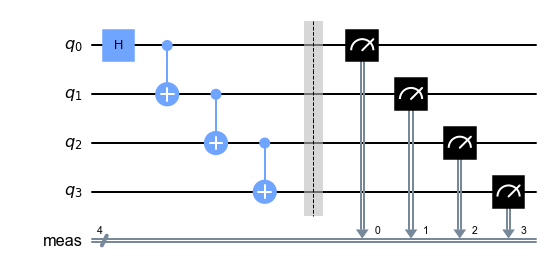

In [152]:
circ = QuantumCircuit(4)
circ.h(0)
circ.cx(0, 1)
circ.cx(1, 2)
circ.cx(2, 3)
circ.measure_all()
# 
durations = InstructionDurations(
    [
        ("h", 0, 50), 
        ("cx", [0, 1], 700), 
        ("cx", [1, 2], 200), 
        ("cx", [2, 3], 300),
        ("measure", None, 1000),
        ("x", None, 50)]
)
circ.draw()

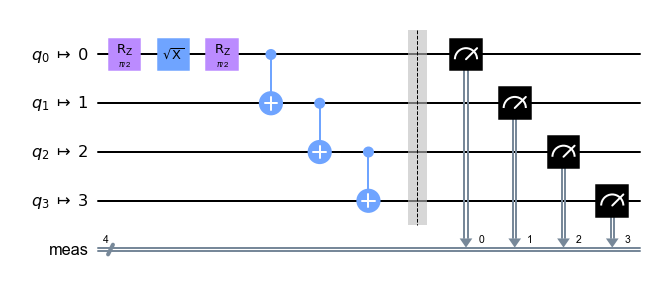

In [ ]:
circuit_transpiled=transpile(circ,backend=backend)
circuit_transpiled.draw(idle_wires=False)

In [91]:
job = backend.run(circuit_transpiled)

In [271]:
sim_job = provider.backend.ibmq_qasm_simulator.run(circ)

In [273]:
print('simulation: ',sim_job.status())
print(job.status(), "position:", job.queue_position())


simulation:  JobStatus.DONE
JobStatus.DONE position: None


### Applying Dynamical Decoupling

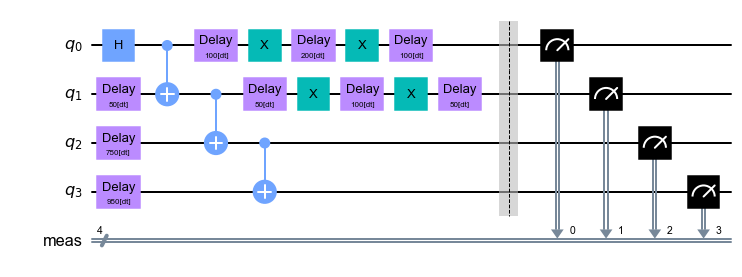

In [53]:
# balanced X-X sequence on all qubits
dd_sequence = [XGate(), XGate()]

pm = PassManager(
    [
        ALAPSchedule(durations),
        DynamicalDecoupling(durations, dd_sequence)
    ]
    )
circ_dd = pm.run(circ)
circ_dd.draw()

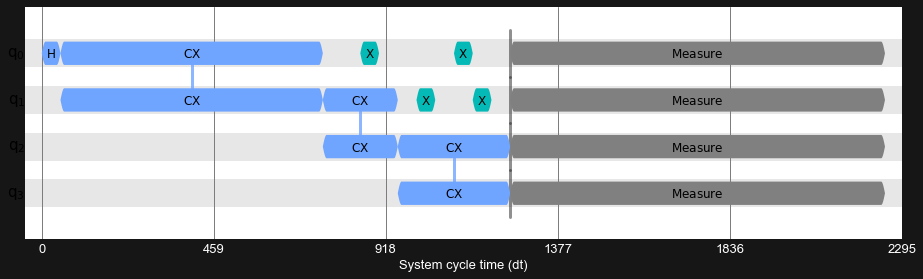

In [28]:
timeline_drawer(circ_dd)

Note that we need to specify a `scheduling_method` now in order to be able to transpile the circuit

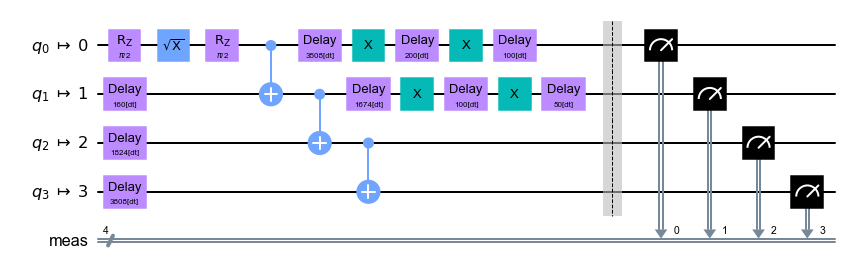

In [279]:
circ_dd_transpiled=transpile(circ_dd,backend, scheduling_method="alap")
circ_dd_transpiled.draw('mpl',idle_wires=False)

In [72]:
dd_job = backend.run(circ_dd_transpiled)

In [278]:
print(dd_job.status(), "position:", dd_job.queue_position())

JobStatus.DONE position: None


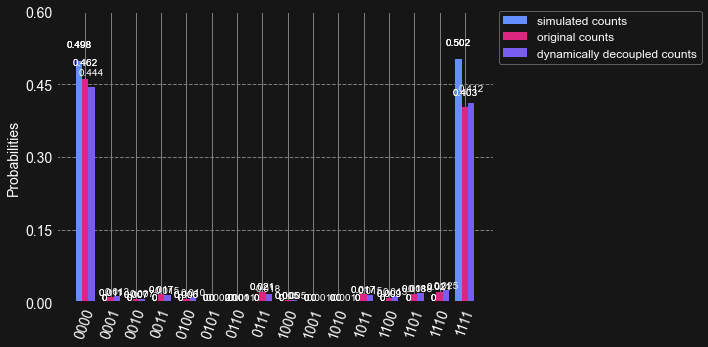

In [97]:
simulated_counts=sim_job.result().get_counts()
counts=job.result().get_counts()
dd_counts = dd_job.result().get_counts()
plot_histogram([simulated_counts,counts,dd_counts], legend=['simulated counts','original counts','dynamically decoupled counts'])

### Varying gate spacing

`DynamicalDecoupling` allows to vary the time between the dynamical decoupling gates by specifing the parameter `spacing`. One way of doing so was given by Prof. Uhrig of TU Dortmund in his paper [Keeping a Quantum Bit Alive by Optimized π-Pulse Sequences](https://arxiv.org/abs/quant-ph/0609203). We can apply his method in the following way

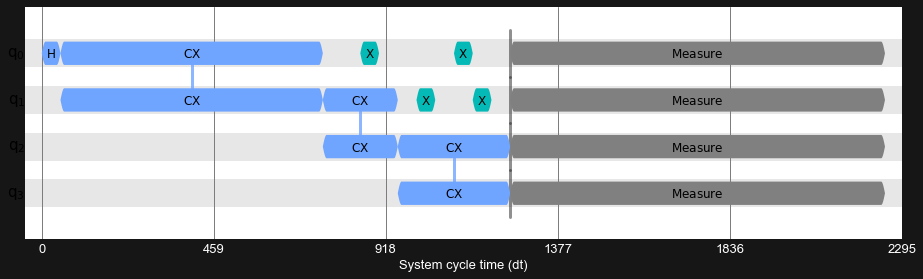

In [153]:
# Uhrig sequence on qubit 0
n = 8
dd_sequence = [XGate()] * n
def uhrig_pulse_location(k):
    return np.sin(np.pi * (k + 1) / (2 * n + 2)) ** 2
spacing = []
for k in range(n):
    spacing.append(uhrig_pulse_location(k) - sum(spacing))
spacing.append(1 - sum(spacing))

pm = PassManager(
    [
        ALAPSchedule(durations),
        DynamicalDecoupling(durations, dd_sequence, qubits=[0], spacing=spacing),
    ]
)
circ_dd_uhrig = pm.run(circ)
timeline_drawer(circ_dd_uhrig)
timeline_drawer(circ_dd)

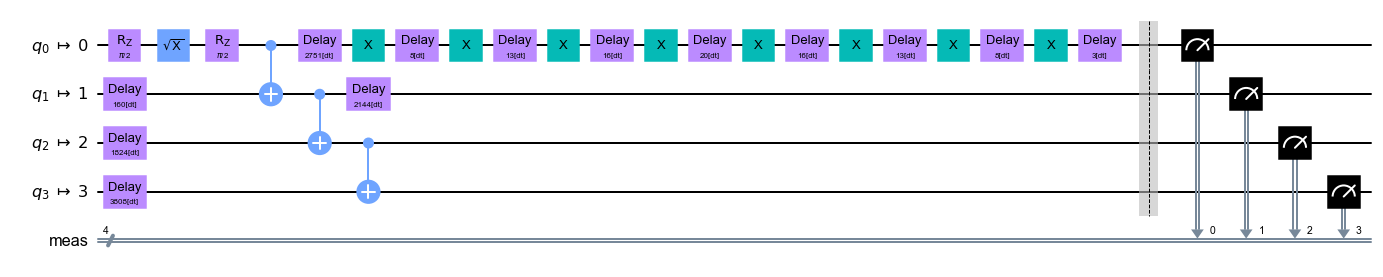

In [146]:
circ_dd_uhrig_transpiled=transpile(circ_dd_uhrig, backend, scheduling_method="alap")
circ_dd_uhrig_transpiled.draw(idle_wires=False,fold=-1)

In [112]:
dd_job_uhrig = backend.run(circ_dd_uhrig_transpiled)

In [280]:
print(dd_job_uhrig.status(), "position:", dd_job_uhrig.queue_position())

JobStatus.DONE position: None


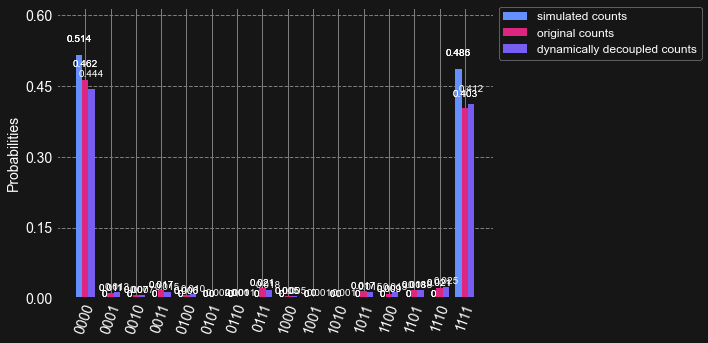

In [281]:
simulated_counts=sim_job.result().get_counts()
counts=job.result().get_counts()
dd_counts = dd_job.result().get_counts()

plot_histogram([simulated_counts,counts,dd_counts], 
legend=['simulated counts','original counts','dynamically decoupled counts'])

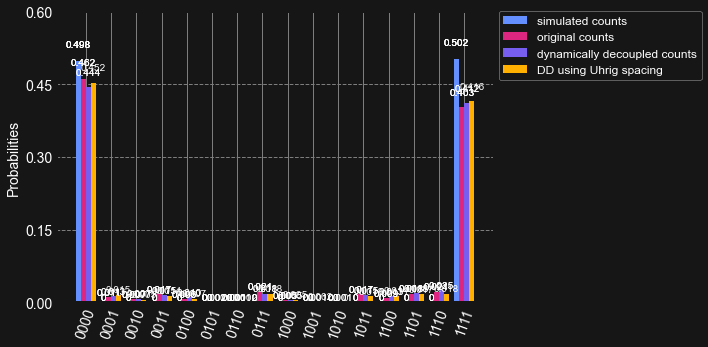

In [130]:
dd_counts_uhrig = dd_job_uhrig.result().get_counts()
plot_histogram([simulated_counts,counts,dd_counts,dd_counts_uhrig], 
legend=['simulated counts','original counts','dynamically decoupled counts','DD using Uhrig spacing'])

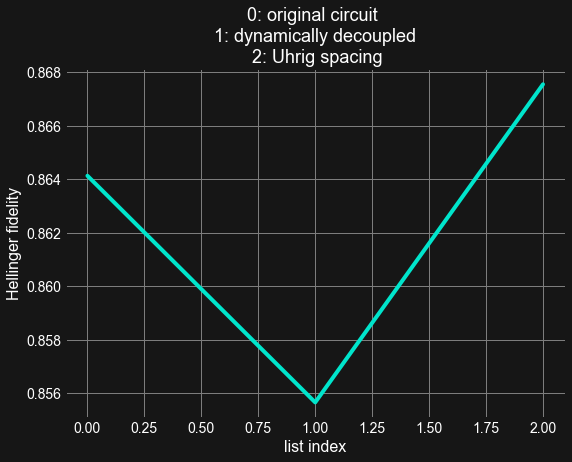

In [133]:
fidelities = [
    hellinger_fidelity(simulated_counts,counts),
    hellinger_fidelity(simulated_counts,dd_counts),
    hellinger_fidelity(simulated_counts,dd_counts_uhrig)
    ]

plt.ylabel('Hellinger fidelity')
plt.xlabel('list index')
plt.title('0: original circuit \n 1: dynamically decoupled \n 2: Uhrig spacing')
plt.plot(fidelities);

We see that Dynamical Decoupling does have effects on the performance of this basic GHZ circuit, however the dynamical decoupling method needs to be carefully chosen.

## Decoupling a mid-circuit measurement

Measurements take up quite some time in the course of a circuit. Let us see the effects of applying dynamical decoupling during a measurement & reset sequence. This circuit is inspired by the IBM research blog's [introduction](https://www.ibm.com/blogs/research/2021/02/quantum-mid-circuit-measurement/) of mid-circuit measurements.

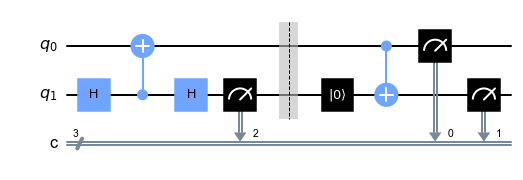

In [195]:
circ_mid_meas = QuantumCircuit(2,3)
circ_mid_meas.h(1)
circ_mid_meas.cx(1, 0)
circ_mid_meas.h(1)
circ_mid_meas.measure(1,2)
circ_mid_meas.barrier(0,1)
circ_mid_meas.reset(1)
circ_mid_meas.cx(0, 1)
circ_mid_meas.measure(0,0)
circ_mid_meas.measure(1,1)

#durations can also be obtained directly from the specific backend
durations_backend = InstructionDurations.from_backend(backend)

circ_mid_meas.draw()

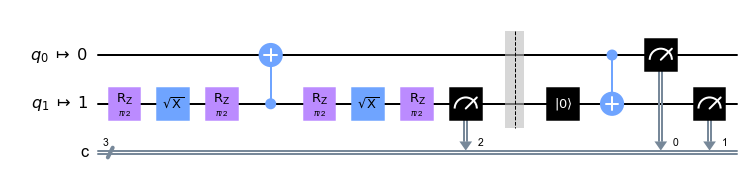

In [196]:
circ_mid_meas_transp=transpile(circ_mid_meas,backend)
circ_mid_meas_transp.draw(idle_wires=False)

In [197]:
simjob_midmeas=provider.backend.ibmq_qasm_simulator.run(circ_mid_meas)
job_midmeas_nodd=backend.run(circ_mid_meas_transp)

In [200]:
print('simulator:',simjob_midmeas.status())
print(backend.name(),job_midmeas_nodd.status(),'position:',job_midmeas_nodd.queue_position())

simulator: JobStatus.DONE
ibmq_ehningen JobStatus.DONE position: None


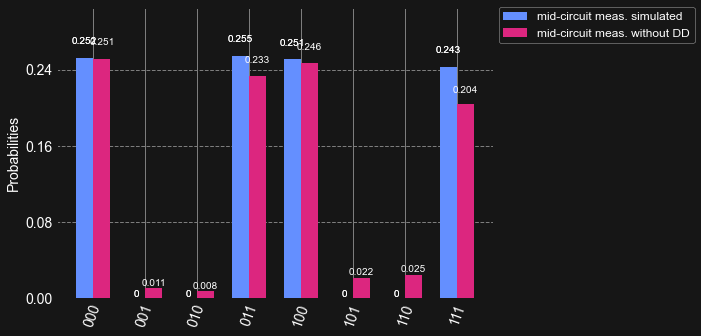

In [201]:
counts_midmeas= job_midmeas_nodd.result().get_counts()
counts_simjob= simjob_midmeas.result().get_counts()
plot_histogram([counts_simjob,counts_midmeas],legend=['mid-circuit meas. simulated','mid-circuit meas. without DD'])

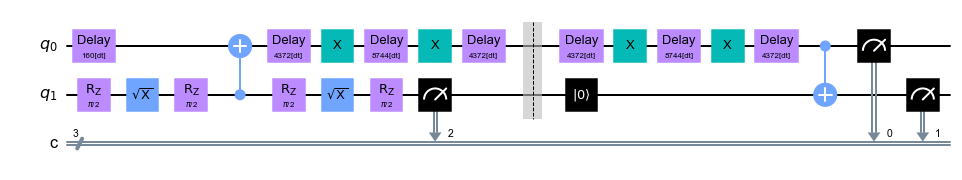

In [202]:
dd_sequence = [XGate(), XGate()]
pm = PassManager([ALAPSchedule(durations_backend),
                  DynamicalDecoupling(durations_backend, dd_sequence)])
circ_dd_midmeas = pm.run(circ_mid_meas_transp)
circ_dd_midmeas.draw(idle_wires=False)

In [203]:
job_dd_midmeas=backend.run(circ_dd_midmeas)

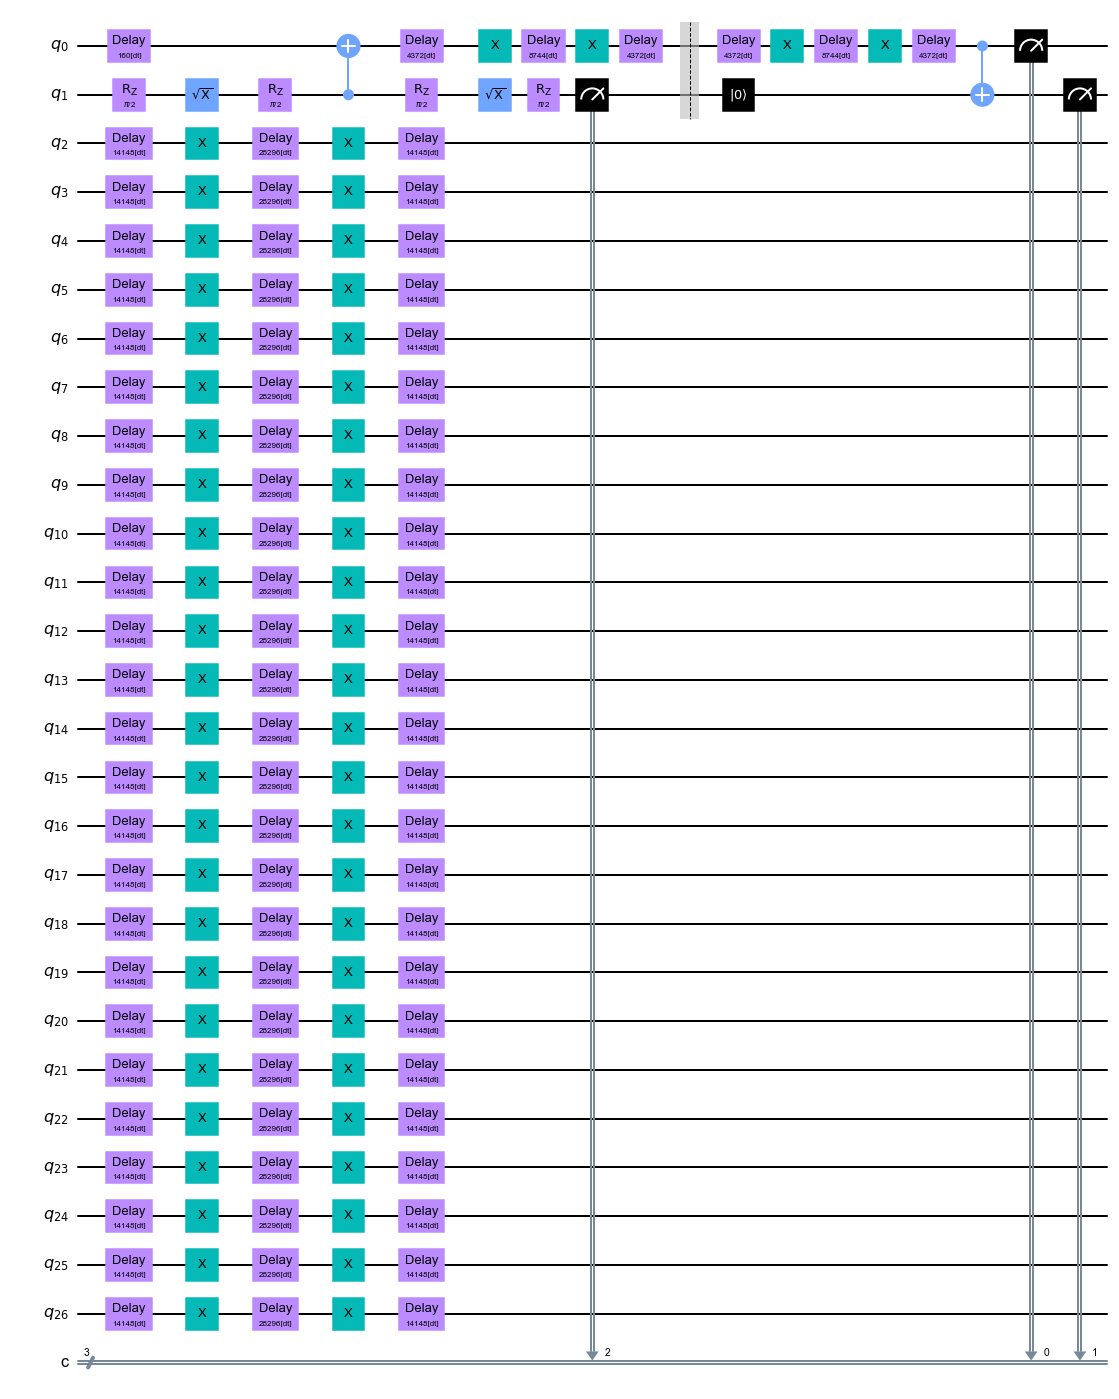

In [204]:
dd_sequence = [XGate(), XGate()]
pm_skipfalse = PassManager([ALAPSchedule(durations_backend),
                  DynamicalDecoupling(durations_backend, dd_sequence,skip_reset_qubits=False)])
circ_dd_midmeas_skipfalse = pm_skipfalse.run(circ_mid_meas_transp)
circ_dd_midmeas_skipfalse.draw(idle_wires=False)

In [205]:
job_dd_midmeas_skipfalse=backend.run(circ_dd_midmeas_skipfalse)

In [207]:
print(backend.name(),job_dd_midmeas.status(),'position:',job_dd_midmeas.queue_position())
print(backend.name(),job_dd_midmeas_skipfalse.status(),'position:',job_dd_midmeas_skipfalse.queue_position())

ibmq_ehningen JobStatus.DONE position: None
ibmq_ehningen JobStatus.RUNNING position: None


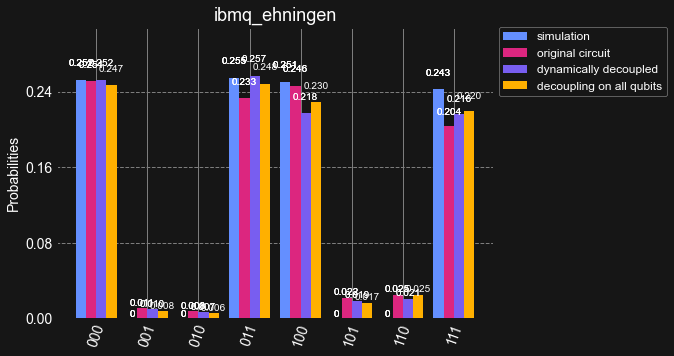

In [208]:
simulated_counts_midmeas=simjob_midmeas.result().get_counts()
counts_midmeas=job_midmeas_nodd.result().get_counts()
counts_dd_midmeas=job_dd_midmeas.result().get_counts()
counts_dd_midmeas_skipfalse=job_dd_midmeas_skipfalse.result().get_counts()

plot_histogram([simulated_counts_midmeas,counts_midmeas,counts_dd_midmeas,counts_dd_midmeas_skipfalse],title=backend.name(), 
legend=['simulation','original circuit','dynamically decoupled','decoupling on all qubits'])

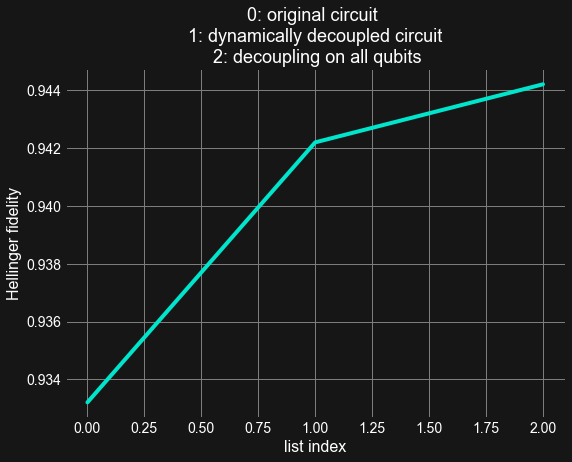

In [215]:
counts_array_midmeas = [
    hellinger_fidelity(simulated_counts_midmeas,counts_midmeas),
    hellinger_fidelity(simulated_counts_midmeas,counts_dd_midmeas),
    hellinger_fidelity(simulated_counts_midmeas,counts_dd_midmeas_skipfalse)]

plt.ylabel('Hellinger fidelity')
plt.xlabel('list index')
plt.title('0: original circuit \n 1: dynamically decoupled circuit \n 2: decoupling on all qubits')
plt.plot(counts_array_midmeas);


Note that applying gates to seemingly unrelated qubits can have effects! This is due to the possible reduction of Spectator Errors, i.e. reducing the influence of neighboring qubits.

## Application to Bernstein-Vazirani

The [Bernstein-Vazirani Algorithm](https://qiskit.org/textbook/ch-algorithms/bernstein-vazirani.html) is a modification of the Deutsch-Josza algorithm. It is constructed to learn a string encoded in a function. Its circuits turn out to possess long idle times and have thus [shown to be well-suited](https://gist.github.com/blakejohnson/9d0d7aa8c50350f869ed3eeca185f8f0) for an application of the kind of dynamical decoupling presented. Let us look at this effect in a concise manner. 

### Setting up the circuit

In [217]:
def create_oracle(num_qubits, input_size, secret_int):
    # Initialize first n qubits and single ancilla qubit
    qc = QuantumCircuit(num_qubits, name=f"Uf")

    # perform CX for each qubit that matches a bit in secret string
    s = ('{0:0' + str(input_size) + 'b}').format(secret_int)
    for i_qubit in range(input_size):
        if s[input_size - 1 - i_qubit] == '1':
            qc.cx(i_qubit, input_size)
    return qc


def bernstein_vazirani(num_qubits, secret_int):
    
    # size of input is one less than available qubits
    input_size = num_qubits - 1

    # setup circuit
    qc = QuantumCircuit(num_qubits, input_size, name="main")

    # put ancilla in |1> state
    qc.x(input_size)

    # start with Hadamard on all qubits, including ancilla
    for i_qubit in range(num_qubits):
         qc.h(i_qubit)

    qc.barrier()

    # generate Uf oracle
    Uf = create_oracle(num_qubits, input_size, secret_int)
    qc.append(Uf, range(num_qubits))

    qc.barrier()

    # Hadamard again on all non-ancilla qubits,
    for i_qubit in range(input_size):
         qc.h(i_qubit)

    qc.barrier()

    # measure all data qubits
    for i in range(input_size):
        qc.measure(i, i)

    return qc

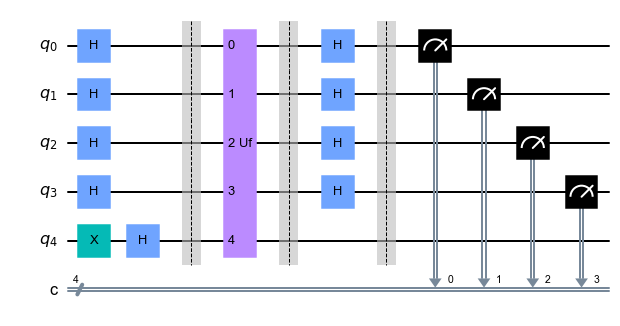

In [269]:
bv_circuit_test = bernstein_vazirani(5, int('1101', 2))
bv_circuit_test.draw('mpl')

### Verifying the functionality in simulation

In [270]:
sim_backend = provider.backend.ibmq_qasm_simulator
sim_job_bv = sim_backend.run(transpile(bv_circuit_test, sim_backend), shots=1)
sim_result = sim_job_bv.result()
sim_result.get_counts()

{'1101': 1}

We get back the binary string we passed to the BV function as desired. Now let's...

### Run the original circuit

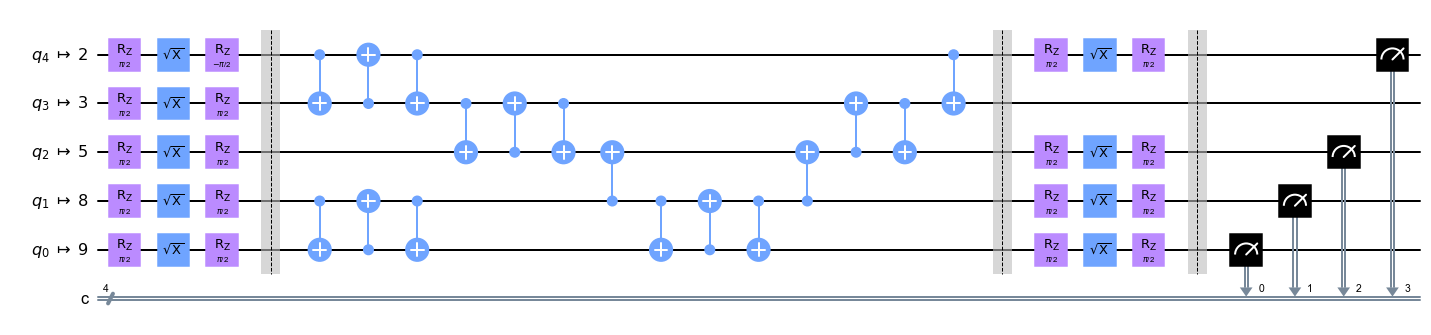

In [258]:
bv_circuit = bernstein_vazirani(5, int('1111', 2))
bv_transpiled = transpile(bv_circuit, backend=backend)
bv_transpiled.draw('mpl',idle_wires=False,fold=-1)

In [227]:
job_bv_original = backend.run(bv_transpiled)

In [284]:
print(backend.name(),job_bv_original.status(),'position:',job_bv_original.queue_position())

ibmq_ehningen JobStatus.DONE position: None


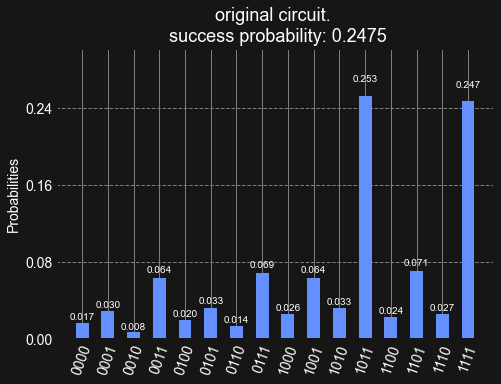

In [282]:
counts_bv_original= job_bv_original.result().get_counts()
#print('no. shots used',job_bv_original.result().results[0].shots)
plot_histogram(counts_bv_original,title='original circuit. \n success probability: '+str(counts_bv_original['1111'] / 4000))


Can't we do better than this? 

### Apply Dynamical Decoupling

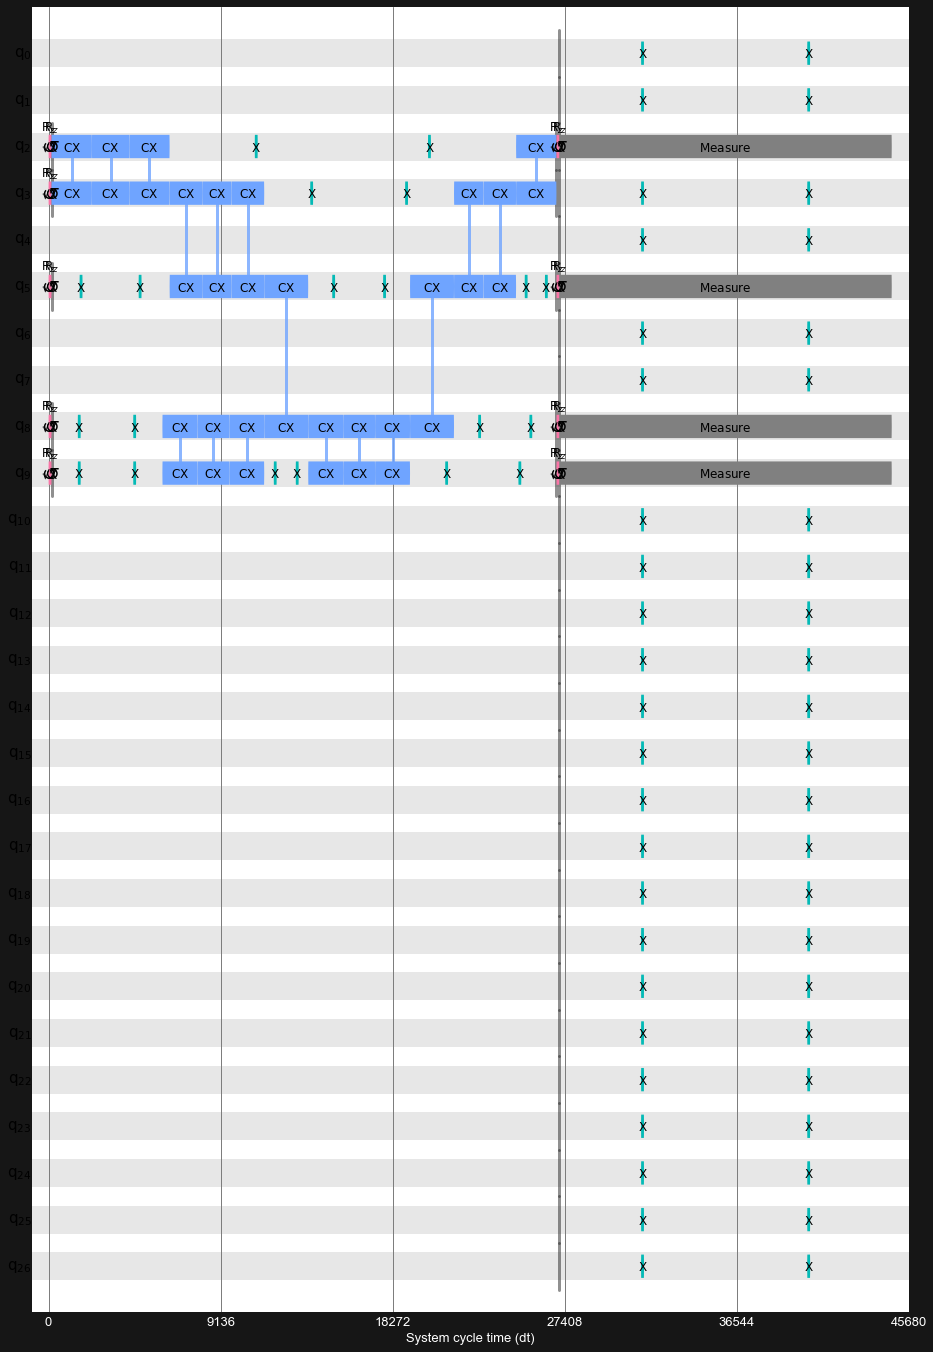

In [257]:
durations_backend = InstructionDurations.from_backend(backend)
dd_sequence = [XGate(), XGate()]
pm = PassManager([ALAPSchedule(durations_backend),
                  DynamicalDecoupling(durations_backend, dd_sequence)])

# transpile and view the resulting schedule
circ_dd_bv = pm.run(bv_transpiled)
timeline_drawer(circ_dd_bv)

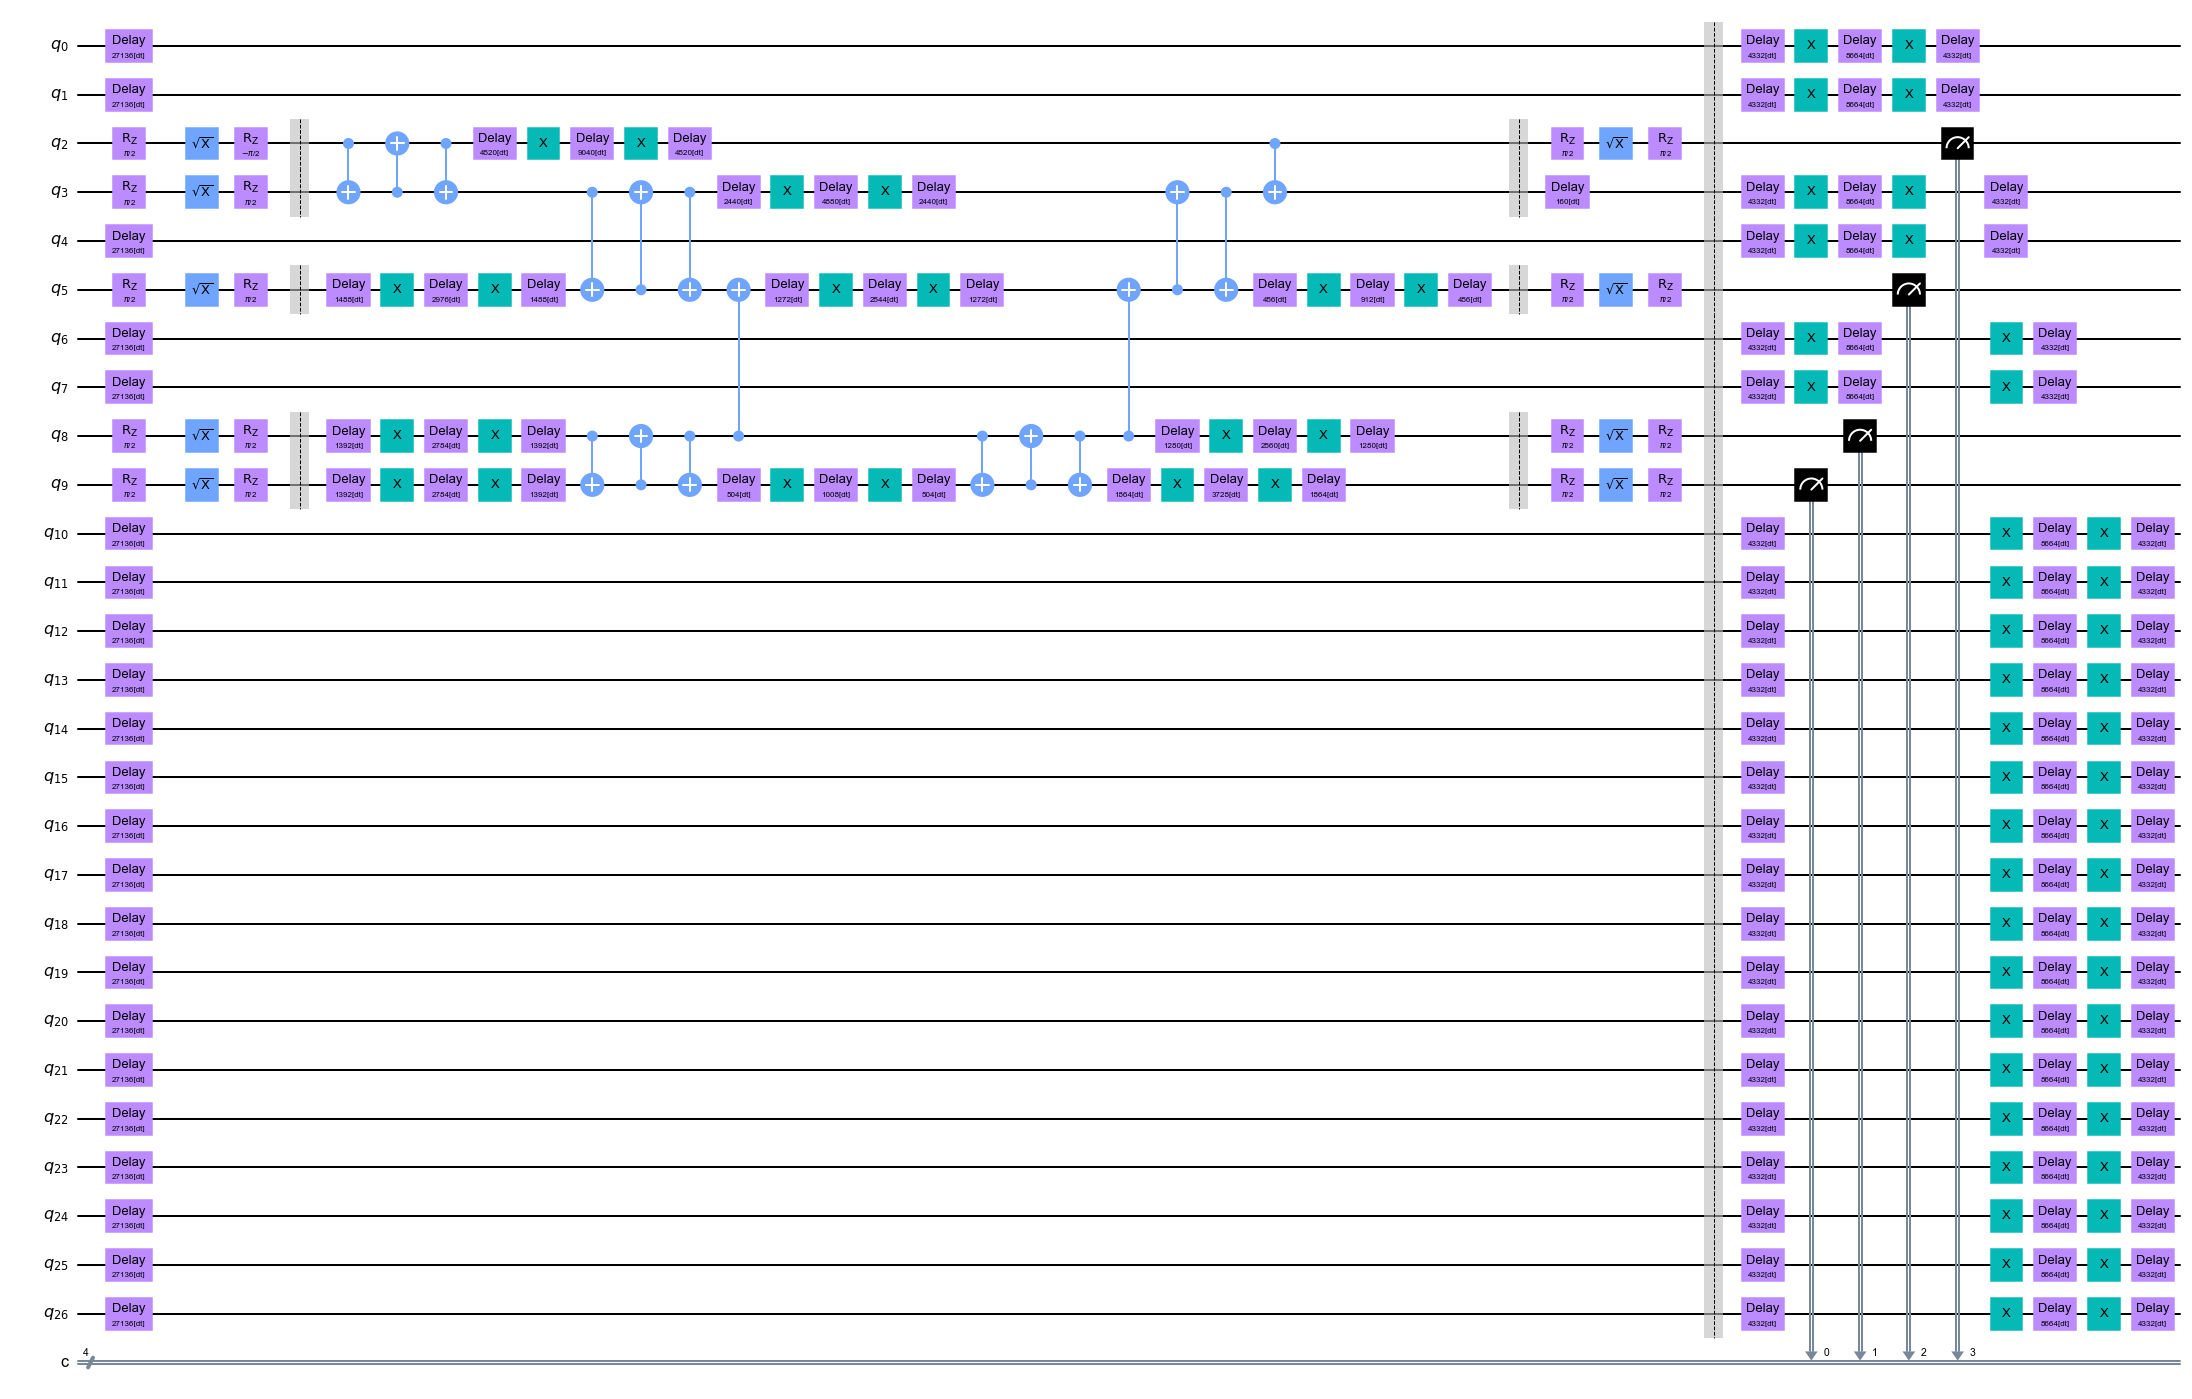

In [260]:
circ_dd_bv.draw('mpl',idle_wires=False,fold=-1)

In [261]:
job_bv_decoupled = backend.run(circ_dd_bv)

In [285]:
print(backend.name(),job_bv_decoupled.status(),'position:',job_bv_decoupled.queue_position())

ibmq_ehningen JobStatus.DONE position: None


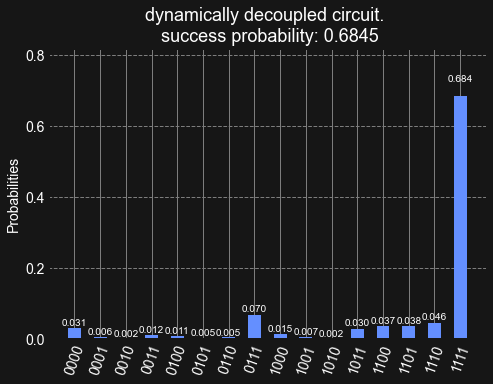

In [267]:
counts_bv_decoupled= job_bv_decoupled.result().get_counts()
#print('no. shots used',job_bv_original.result().results[0].shots)
plot_histogram(counts_bv_decoupled,title='dynamically decoupled circuit. \n success probability: '+str(
    counts_bv_decoupled['1111'] / 4000))

Summa: Do use dynamical decoupling, especially if your circuits contain lots of idle time for some qubits!

In [2]:
%qiskit_version_table

Qiskit Software,Version
qiskit-terra,0.19.0
qiskit-aer,0.9.1
qiskit-ignis,0.7.0
qiskit-ibmq-provider,0.18.1
qiskit-aqua,0.9.5
qiskit,0.33.0
qiskit-nature,0.2.2
qiskit-finance,0.2.1
qiskit-optimization,0.2.3
qiskit-machine-learning,0.2.1
